In [116]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
df1 = pd.read_csv('data/both_vectors.csv')
allvec = df1
id_vec = df1[df1.columns[0:3]]
text_vec = df1[df1.columns[3:303]]
image_vec = df1[df1.columns[303:4398]]

In [16]:
# Hand-labeled categories
hand_df = pd.read_csv('data/lookup_table.csv', delimiter=',')
hand = []
for i in range(0, len(id_vec)):
    a = hand_df[hand_df.SS==id_vec.category[i].strip()].HAND
    if (len(a)>0):
        hand.append(a.values[0])
    else:
        hand.append('NA')

In [18]:
handdf = pd.DataFrame()
handdf['hand'] = hand
# Get rid of NA rows
all_withhand = pd.concat((id_vec, handdf, text_vec, image_vec), axis=1)
all_withhand = all_withhand[all_withhand.hand != 'NA']

In [28]:
# Get new subsets
Hid_vec = all_withhand[all_withhand.columns[0:4]]
Htext_vec = all_withhand[all_withhand.columns[4:304]]
Himage_vec = all_withhand[all_withhand.columns[304:4399]]
len(np.unique(all_withhand.hand))

27

## Balance categories

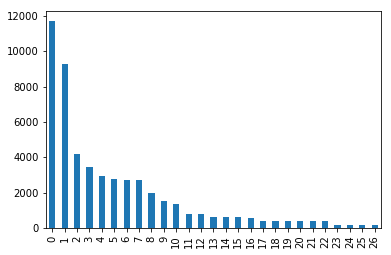

In [36]:
Hid_vec.hand.value_counts().plot.bar(use_index=False)
# Don't show labels because of NDA

For this, only use items with at least 1k, and cut everything off to 1k. Randomly select which 1k to use.

In [37]:
handover1k = all_withhand.hand.value_counts() > 1000
handover1k = handover1k[handover1k]
handover1k = handover1k.index
len(handover1k)

11

In [24]:
allhand = pd.DataFrame()
for cat in handover1k:
    mycat = all_withhand[all_withhand.hand==cat]
    mycat = mycat.sample(n=1000, random_state=0)
    allhand = allhand.append(mycat)

# Reduce dimensionality in image vector
### (sparse 4k matrix --> dense 300)

In [38]:
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=0)
allhand_id = allhand[allhand.columns[0:4]]
allhand_text = allhand[allhand.columns[4:304]]
allhand_imageFULL = allhand[allhand.columns[304:4399]]

allhand_image = svd.fit_transform(allhand_imageFULL)
allhand_image = pd.DataFrame(allhand_image)
allhand_image.index = allhand_imageFULL.index

allhand_reduced = pd.concat([allhand_id, allhand_text, allhand_image], axis=1)
# allhand_reduced.to_csv('handlabeled_vectors.csv')
allhand = allhand_reduced

### Check feature variances

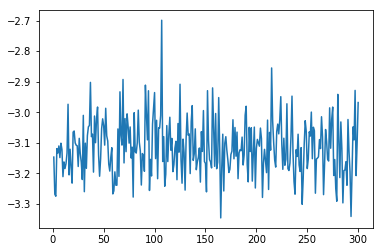

In [26]:
plt.plot(np.log(np.std(allhand_text, axis=0)))

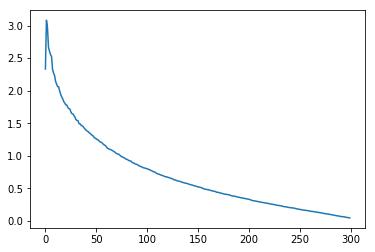

In [27]:
plt.plot(np.log(np.std(allhand_image, axis=0)))

# Supervised Classification
### How easy is it to classify into their hand-labeled categories?

#### From text alone

In [82]:
X = allhand_text
y = allhand_id.hand
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [93]:
# Try logistic regression
tic = time.time()
lr = LogisticRegression(random_state=1)
lr.fit(X, y)
lr_y_pred = lr.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, lr_y_pred)))
print(classification_report(y_test, lr_y_pred))
print(confusion_matrix(y_test, lr_y_pred))

Time: 7.652992010116577 seconds.
Accuracty: 0.845090909091
             precision    recall  f1-score   support

       bags       0.96      0.97      0.96       237
      coats       0.85      0.86      0.85       270
    dresses       0.75      0.86      0.80       240
    jackets       0.82      0.76      0.79       250
     shirts       0.76      0.76      0.76       227
      shoes       0.97      0.96      0.96       253
     shorts       0.76      0.76      0.76       251
     skirts       0.89      0.85      0.87       266
   swimwear       0.88      0.87      0.88       263
   trousers       0.78      0.86      0.82       244
  underwear       0.88      0.78      0.83       249

avg / total       0.85      0.85      0.85      2750

[[230   0   0   2   0   0   0   0   5   0   0]
 [  0 232   3  21   5   0   1   2   2   3   1]
 [  0   1 206   3  10   1   5   6   2   3   3]
 [  1  27   6 191  12   0   5   1   3   3   1]
 [  1   5  15   6 172   1   6   5   1  11   4]
 [  2   0   2 

In [96]:
# Try linear SVM
tic = time.time()
svc = LinearSVC(random_state=1)
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, svc_y_pred)))
print(classification_report(y_test, svc_y_pred))
print(confusion_matrix(y_test, svc_y_pred))

Time: 4.889408111572266 seconds.
Accuracty: 0.847272727273
             precision    recall  f1-score   support

       bags       0.96      0.96      0.96       237
      coats       0.86      0.84      0.85       270
    dresses       0.78      0.83      0.81       240
    jackets       0.82      0.80      0.81       250
     shirts       0.76      0.76      0.76       227
      shoes       0.95      0.95      0.95       253
     shorts       0.76      0.79      0.77       251
     skirts       0.88      0.84      0.86       266
   swimwear       0.90      0.90      0.90       263
   trousers       0.82      0.86      0.84       244
  underwear       0.83      0.80      0.81       249

avg / total       0.85      0.85      0.85      2750

[[228   0   0   2   1   0   0   1   4   0   1]
 [  0 226   2  27   5   1   2   2   2   2   1]
 [  0   1 199   3  13   2   6   8   1   1   6]
 [  2  25   3 199   9   0   2   3   1   5   1]
 [  1   3  15   5 172   1   4   6   1  11   8]
 [  2   0   1 

In [98]:
# Try naive bayes
tic = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, gnb_y_pred)))
print(classification_report(y_test, gnb_y_pred))
print(confusion_matrix(y_test, gnb_y_pred))

Time: 0.24440407752990723 seconds.
Accuracty: 0.527272727273
             precision    recall  f1-score   support

       bags       0.95      0.74      0.83       237
      coats       0.69      0.37      0.48       270
    dresses       0.53      0.74      0.62       240
    jackets       0.40      0.58      0.47       250
     shirts       0.61      0.32      0.42       227
      shoes       0.96      0.72      0.82       253
     shorts       0.49      0.13      0.21       251
     skirts       0.76      0.48      0.59       266
   swimwear       0.37      0.78      0.50       263
   trousers       0.48      0.68      0.56       244
  underwear       0.24      0.25      0.24       249

avg / total       0.59      0.53      0.52      2750

[[175   0   3  18   0   4   0   0  24   1  12]
 [  1 100   8 120   6   0   2   0   8   6  19]
 [  0   2 178   7  11   0   0   6  13   5  18]
 [  5  27   9 146   8   1   2   3  28   7  14]
 [  0   5  29  35  72   0   1   5  33  26  21]
 [  0   3  1

In [108]:
# Try KNN
tic = time.time()
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
toc = time.time()

print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, knn_y_pred)))
print(classification_report(y_test, knn_y_pred))
print(confusion_matrix(y_test, knn_y_pred))


Time: 18.598824977874756 seconds.
Accuracty: 0.723636363636
             precision    recall  f1-score   support

       bags       0.88      0.92      0.90       237
      coats       0.69      0.81      0.74       270
    dresses       0.57      0.78      0.66       240
    jackets       0.56      0.67      0.61       250
     shirts       0.77      0.46      0.57       227
      shoes       0.97      0.82      0.89       253
     shorts       0.66      0.69      0.67       251
     skirts       0.78      0.62      0.69       266
   swimwear       0.75      0.86      0.80       263
   trousers       0.70      0.73      0.71       244
  underwear       0.82      0.59      0.68       249

avg / total       0.74      0.72      0.72      2750

[[219   0   1   2   2   3   1   2   4   0   3]
 [  5 220   3  26   7   0   0   2   1   5   1]
 [  0   8 187  13   6   1   7   8   4   5   1]
 [  3  50   7 167   1   1   8   3   4   6   0]
 [  3  19  32  28 104   1   9   4   5  14   8]
 [  7   3   5

In [109]:
# Try decision tree, maybe random forest later
tic = time.time()
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, dt_y_pred)))
print(classification_report(y_test, dt_y_pred))
print(confusion_matrix(y_test, dt_y_pred))

Time: 5.286087989807129 seconds.
Accuracty: 0.476727272727
             precision    recall  f1-score   support

       bags       0.69      0.68      0.68       237
      coats       0.57      0.50      0.53       270
    dresses       0.47      0.49      0.48       240
    jackets       0.39      0.40      0.40       250
     shirts       0.28      0.29      0.29       227
      shoes       0.62      0.58      0.60       253
     shorts       0.44      0.49      0.46       251
     skirts       0.47      0.46      0.46       266
   swimwear       0.52      0.50      0.51       263
   trousers       0.40      0.41      0.40       244
  underwear       0.43      0.43      0.43       249

avg / total       0.48      0.48      0.48      2750

[[160   8   6   6   6  18   6   6   9   1  11]
 [  7 136   9  44  21  11   6   7  11  12   6]
 [  4   6 118  10  22   7  11  20  11  12  19]
 [  9  33  12 101  25   5  18  15   7  20   5]
 [  6  13  16  18  66  10  19  18  11  31  19]
 [ 18   9  10 

In [173]:
# Try neural network

# Reshape data
# Data to numpy arrays
npy_X_test = X_test.values
npy_X_train = X_train.values

# One-hot encode labels
encoder = LabelEncoder()
encoder.fit(y)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
onehot_y_train = np_utils.to_categorical(encoded_y_train)
onehot_y_test = np_utils.to_categorical(encoded_y_test)

# Build model
nn = Sequential()
nn.add(Dense(100, input_dim=300, activation='relu'))
nn.add(Dense(11, activation='softmax'))
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train & Test
nn.fit(npy_X_train, onehot_y_train,
       validation_data=(npy_X_test, onehot_y_test),
       epochs=100, batch_size=50)

Train on 8250 samples, validate on 2750 samples
Epoch 1/100
8250/8250 [==============================] - 1s - loss: 2.0036 - acc: 0.4864 - val_loss: 1.5529 - val_acc: 0.6491
Epoch 2/100
8250/8250 [==============================] - 0s - loss: 1.2848 - acc: 0.6762 - val_loss: 1.0972 - val_acc: 0.7102
Epoch 3/100
8250/8250 [==============================] - 0s - loss: 0.9847 - acc: 0.7372 - val_loss: 0.9054 - val_acc: 0.7589
Epoch 4/100
8250/8250 [==============================] - 0s - loss: 0.8352 - acc: 0.7714 - val_loss: 0.8029 - val_acc: 0.7789
Epoch 5/100
8250/8250 [==============================] - 0s - loss: 0.7462 - acc: 0.7919 - val_loss: 0.7383 - val_acc: 0.7949
Epoch 6/100
8250/8250 [==============================] - 0s - loss: 0.6841 - acc: 0.8055 - val_loss: 0.6945 - val_acc: 0.8029
Epoch 7/100
8250/8250 [==============================] - 0s - loss: 0.6367 - acc: 0.8159 - val_loss: 0.6668 - val_acc: 0.8098
Epoch 8/100
8250/8250 [==============================] - 0s - loss: 0.

8250/8250 [==============================] - 0s - loss: 0.2061 - acc: 0.9434 - val_loss: 0.5829 - val_acc: 0.8484
Epoch 66/100
8250/8250 [==============================] - 0s - loss: 0.2049 - acc: 0.9433 - val_loss: 0.5893 - val_acc: 0.8553
Epoch 67/100
8250/8250 [==============================] - 0s - loss: 0.2002 - acc: 0.9468 - val_loss: 0.5910 - val_acc: 0.8476
Epoch 68/100
8250/8250 [==============================] - 0s - loss: 0.1999 - acc: 0.9450 - val_loss: 0.5916 - val_acc: 0.8473
Epoch 69/100
8250/8250 [==============================] - 0s - loss: 0.1957 - acc: 0.9474 - val_loss: 0.5914 - val_acc: 0.8513
Epoch 70/100
8250/8250 [==============================] - 0s - loss: 0.1921 - acc: 0.9498 - val_loss: 0.5980 - val_acc: 0.8538
Epoch 71/100
8250/8250 [==============================] - 0s - loss: 0.1914 - acc: 0.9472 - val_loss: 0.5974 - val_acc: 0.8549
Epoch 72/100
8250/8250 [==============================] - 0s - loss: 0.1901 - acc: 0.9468 - val_loss: 0.6002 - val_acc: 0.85

#### From image alone

In [174]:
X = allhand_image
y = allhand_id.hand
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [175]:
# Try logistic regression
tic = time.time()
lr = LogisticRegression(random_state=1)
lr.fit(X, y)
lr_y_pred = lr.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, lr_y_pred)))
print(classification_report(y_test, lr_y_pred))
print(confusion_matrix(y_test, lr_y_pred))

Time: 41.384730100631714 seconds.
Accuracty: 0.840727272727
             precision    recall  f1-score   support

       bags       1.00      1.00      1.00       237
      coats       0.79      0.84      0.81       270
    dresses       0.76      0.85      0.80       240
    jackets       0.78      0.77      0.78       250
     shirts       0.76      0.70      0.73       227
      shoes       1.00      1.00      1.00       253
     shorts       0.76      0.80      0.78       251
     skirts       0.84      0.82      0.83       266
   swimwear       0.85      0.77      0.81       263
   trousers       0.87      0.93      0.90       244
  underwear       0.84      0.78      0.81       249

avg / total       0.84      0.84      0.84      2750

[[236   0   0   0   0   0   0   1   0   0   0]
 [  0 226   6  28   5   0   0   4   0   1   0]
 [  0   5 204   0   6   0  12   4   4   3   2]
 [  0  37   1 193  16   0   2   0   0   1   0]
 [  0   8   7  20 159   0   6   1   6  17   3]
 [  0   0   0

In [176]:
# Try linear SVM
tic = time.time()
svc = LinearSVC(random_state=1)
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, svc_y_pred)))
print(classification_report(y_test, svc_y_pred))
print(confusion_matrix(y_test, svc_y_pred))

Time: 36.4244019985199 seconds.
Accuracty: 0.729818181818
             precision    recall  f1-score   support

       bags       0.96      0.95      0.96       237
      coats       0.65      0.79      0.71       270
    dresses       0.69      0.64      0.67       240
    jackets       0.75      0.46      0.57       250
     shirts       0.59      0.59      0.59       227
      shoes       0.95      0.97      0.96       253
     shorts       0.68      0.71      0.69       251
     skirts       0.55      0.78      0.65       266
   swimwear       0.76      0.68      0.72       263
   trousers       0.77      0.87      0.82       244
  underwear       0.80      0.59      0.68       249

avg / total       0.74      0.73      0.73      2750

[[225   2   0   1   2   2   0   2   2   0   1]
 [  2 213   6  19  18   1   0   7   0   3   1]
 [  1   6 154   2   9   1   9  40   9   6   3]
 [  0  77   1 114  41   0   8   5   0   4   0]
 [  1  20   6  11 133   0  10  13   3  21   9]
 [  0   0   3  

In [177]:
# Try naive bayes
tic = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, gnb_y_pred)))
print(classification_report(y_test, gnb_y_pred))
print(confusion_matrix(y_test, gnb_y_pred))

Time: 0.3433060646057129 seconds.
Accuracty: 0.604727272727
             precision    recall  f1-score   support

       bags       0.68      0.84      0.75       237
      coats       0.66      0.50      0.57       270
    dresses       0.66      0.51      0.58       240
    jackets       0.56      0.61      0.59       250
     shirts       0.67      0.48      0.56       227
      shoes       0.85      0.84      0.85       253
     shorts       0.38      0.80      0.52       251
     skirts       0.83      0.52      0.64       266
   swimwear       0.71      0.46      0.56       263
   trousers       0.79      0.71      0.75       244
  underwear       0.33      0.41      0.36       249

avg / total       0.65      0.60      0.61      2750

[[198   0   0   1   5   5   5   4   1   0  18]
 [ 12 134   2  87   4   2   8   0   0   6  15]
 [ 13   4 122   2   3   5  56   4   1   6  24]
 [  4  42   0 153  18   0  18   2   0   4   9]
 [  9  12   8  20 109   1  34   2   3  15  14]
 [  3   3   0

In [178]:
# Try KNN
tic = time.time()
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
toc = time.time()

print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, knn_y_pred)))
print(classification_report(y_test, knn_y_pred))
print(confusion_matrix(y_test, knn_y_pred))

Time: 14.676937818527222 seconds.
Accuracty: 0.743272727273
             precision    recall  f1-score   support

       bags       0.95      0.96      0.96       237
      coats       0.69      0.70      0.70       270
    dresses       0.59      0.73      0.65       240
    jackets       0.64      0.62      0.63       250
     shirts       0.67      0.60      0.63       227
      shoes       0.98      0.97      0.97       253
     shorts       0.63      0.81      0.71       251
     skirts       0.67      0.59      0.63       266
   swimwear       0.81      0.69      0.74       263
   trousers       0.85      0.83      0.84       244
  underwear       0.78      0.68      0.73       249

avg / total       0.75      0.74      0.74      2750

[[227   2   1   0   0   1   0   3   0   2   1]
 [  1 189   7  55   8   0   0   9   0   1   0]
 [  2   4 176   5   7   1  17  21   5   1   1]
 [  0  55   6 155  30   0   4   0   0   0   0]
 [  0  11  20  25 137   0   5   8   2  13   6]
 [  4   0   1

In [179]:
# Try decision tree, maybe random forest later
tic = time.time()
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, dt_y_pred)))
print(classification_report(y_test, dt_y_pred))
print(confusion_matrix(y_test, dt_y_pred))

Time: 5.425737142562866 seconds.
Accuracty: 0.585090909091
             precision    recall  f1-score   support

       bags       0.89      0.88      0.88       237
      coats       0.53      0.54      0.54       270
    dresses       0.49      0.47      0.48       240
    jackets       0.47      0.46      0.46       250
     shirts       0.39      0.41      0.40       227
      shoes       0.92      0.92      0.92       253
     shorts       0.50      0.57      0.53       251
     skirts       0.52      0.50      0.51       266
   swimwear       0.56      0.54      0.55       263
   trousers       0.70      0.67      0.68       244
  underwear       0.50      0.48      0.49       249

avg / total       0.59      0.59      0.59      2750

[[208   3   0   1   4   4   1   3   4   2   7]
 [  1 145  13  62  24   2   7   5   0   6   5]
 [  6  11 114  10  16   2  17  33  13   7  11]
 [  0  67   6 115  38   0   7   2   0  11   4]
 [  3  22  16  34  92   3  11  11   8  14  13]
 [  2   1   2 

In [180]:
# Try neural network
tic = time.time()

# Reshape data
# Data to numpy arrays
npy_X_test = X_test.values
npy_X_train = X_train.values

# One-hot encode labels
encoder = LabelEncoder()
encoder.fit(y)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
onehot_y_train = np_utils.to_categorical(encoded_y_train)
onehot_y_test = np_utils.to_categorical(encoded_y_test)

# Build model
nn = Sequential()
nn.add(Dense(100, input_dim=300, activation='relu'))
nn.add(Dense(11, activation='softmax'))
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train & Test
nn.fit(npy_X_train, onehot_y_train,
       validation_data=(npy_X_test, onehot_y_test),
       epochs=100, batch_size=50)

toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )


Train on 8250 samples, validate on 2750 samples
Epoch 1/100
8250/8250 [==============================] - 1s - loss: 1.8128 - acc: 0.5807 - val_loss: 0.9167 - val_acc: 0.7105
Epoch 2/100
8250/8250 [==============================] - 1s - loss: 0.6866 - acc: 0.7762 - val_loss: 0.7979 - val_acc: 0.7455
Epoch 3/100
8250/8250 [==============================] - 0s - loss: 0.5268 - acc: 0.8205 - val_loss: 0.7636 - val_acc: 0.7582
Epoch 4/100
8250/8250 [==============================] - 0s - loss: 0.4387 - acc: 0.8524 - val_loss: 0.7738 - val_acc: 0.7567
Epoch 5/100
8250/8250 [==============================] - 0s - loss: 0.3716 - acc: 0.8768 - val_loss: 0.7833 - val_acc: 0.7560
Epoch 6/100
8250/8250 [==============================] - 0s - loss: 0.3205 - acc: 0.8933 - val_loss: 0.8109 - val_acc: 0.7545
Epoch 7/100
8250/8250 [==============================] - 0s - loss: 0.2751 - acc: 0.9122 - val_loss: 0.8137 - val_acc: 0.7651
Epoch 8/100
8250/8250 [==============================] - 0s - loss: 0.

8250/8250 [==============================] - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 1.7089 - val_acc: 0.7687
Epoch 65/100
8250/8250 [==============================] - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 1.7139 - val_acc: 0.7665
Epoch 66/100
8250/8250 [==============================] - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 1.7183 - val_acc: 0.7673
Epoch 67/100
8250/8250 [==============================] - 1s - loss: 9.9424e-04 - acc: 1.0000 - val_loss: 1.7232 - val_acc: 0.7676
Epoch 68/100
8250/8250 [==============================] - 0s - loss: 9.1579e-04 - acc: 1.0000 - val_loss: 1.7285 - val_acc: 0.7669
Epoch 69/100
8250/8250 [==============================] - 0s - loss: 8.4809e-04 - acc: 1.0000 - val_loss: 1.7329 - val_acc: 0.7695
Epoch 70/100
8250/8250 [==============================] - 0s - loss: 8.1109e-04 - acc: 1.0000 - val_loss: 1.7358 - val_acc: 0.7687
Epoch 71/100
8250/8250 [==============================] - 0s - loss: 0.0011 - acc: 0.9999 - val_loss: 1.7507

#### From text and image

In [189]:
X = allhand[allhand.columns[4:]]
y = allhand_id.hand
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [190]:
# Try logistic regression
tic = time.time()
lr = LogisticRegression(random_state=1)
lr.fit(X, y)
lr_y_pred = lr.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, lr_y_pred)))
print(classification_report(y_test, lr_y_pred))
print(confusion_matrix(y_test, lr_y_pred))

Time: 199.36328291893005 seconds.
Accuracty: 0.912363636364
             precision    recall  f1-score   support

       bags       1.00      1.00      1.00       237
      coats       0.87      0.89      0.88       270
    dresses       0.86      0.94      0.90       240
    jackets       0.86      0.86      0.86       250
     shirts       0.90      0.82      0.86       227
      shoes       1.00      1.00      1.00       253
     shorts       0.85      0.90      0.87       251
     skirts       0.92      0.92      0.92       266
   swimwear       0.94      0.90      0.92       263
   trousers       0.91      0.96      0.93       244
  underwear       0.93      0.84      0.88       249

avg / total       0.91      0.91      0.91      2750

[[237   0   0   0   0   0   0   0   0   0   0]
 [  0 240   4  22   2   0   0   2   0   0   0]
 [  0   2 226   0   2   0   8   0   0   1   1]
 [  0  26   1 215   6   0   1   0   0   1   0]
 [  0   2   3   9 186   0   5   0   4  13   5]
 [  0   0   0

In [191]:
# Try linear SVM
tic = time.time()
svc = LinearSVC(random_state=1)
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, svc_y_pred)))
print(classification_report(y_test, svc_y_pred))
print(confusion_matrix(y_test, svc_y_pred))

Time: 54.0937180519104 seconds.
Accuracty: 0.775272727273
             precision    recall  f1-score   support

       bags       0.96      0.94      0.95       237
      coats       0.89      0.40      0.56       270
    dresses       0.81      0.57      0.67       240
    jackets       0.61      0.90      0.72       250
     shirts       0.66      0.73      0.69       227
      shoes       0.96      0.98      0.97       253
     shorts       0.67      0.84      0.75       251
     skirts       0.81      0.73      0.77       266
   swimwear       0.77      0.83      0.80       263
   trousers       0.76      0.91      0.83       244
  underwear       0.82      0.72      0.77       249

avg / total       0.79      0.78      0.77      2750

[[223   0   1   4   2   2   0   1   1   0   3]
 [  1 109   6 106  29   1   1   9   1   6   1]
 [  2   2 137   8  19   2  24  12  14  10  10]
 [  0   7   2 225  10   0   2   1   0   2   1]
 [  1   2   1  19 165   0   5   1   8  20   5]
 [  1   1   1  

In [192]:
# Try naive bayes
tic = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, gnb_y_pred)))
print(classification_report(y_test, gnb_y_pred))
print(confusion_matrix(y_test, gnb_y_pred))

Time: 0.5294129848480225 seconds.
Accuracty: 0.625818181818
             precision    recall  f1-score   support

       bags       0.94      0.91      0.93       237
      coats       0.73      0.47      0.58       270
    dresses       0.60      0.75      0.67       240
    jackets       0.52      0.69      0.59       250
     shirts       0.72      0.37      0.49       227
      shoes       0.90      0.87      0.89       253
     shorts       0.60      0.36      0.45       251
     skirts       0.85      0.57      0.68       266
   swimwear       0.49      0.79      0.60       263
   trousers       0.55      0.74      0.63       244
  underwear       0.33      0.36      0.34       249

avg / total       0.66      0.63      0.62      2750

[[216   0   1   3   0   1   0   1   7   0   8]
 [  1 128   3 102   7   3   2   2   6   1  15]
 [  1   0 181   3   9   3   5   4   7   8  19]
 [  2  34   5 173   6   0   2   0   8   6  14]
 [  0   6  26  35  83   0   4   2  24  28  19]
 [  0   1   2

In [193]:
# Try KNN
tic = time.time()
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
toc = time.time()

print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, knn_y_pred)))
print(classification_report(y_test, knn_y_pred))
print(confusion_matrix(y_test, knn_y_pred))

Time: 26.06452703475952 seconds.
Accuracty: 0.743272727273
             precision    recall  f1-score   support

       bags       0.95      0.96      0.96       237
      coats       0.69      0.70      0.70       270
    dresses       0.59      0.73      0.65       240
    jackets       0.64      0.62      0.63       250
     shirts       0.67      0.60      0.63       227
      shoes       0.98      0.97      0.97       253
     shorts       0.63      0.81      0.71       251
     skirts       0.67      0.59      0.63       266
   swimwear       0.81      0.69      0.74       263
   trousers       0.85      0.83      0.84       244
  underwear       0.78      0.68      0.73       249

avg / total       0.75      0.74      0.74      2750

[[227   2   1   0   0   1   0   3   0   2   1]
 [  1 189   7  55   8   0   0   9   0   1   0]
 [  2   4 176   5   7   1  17  21   5   1   1]
 [  0  55   6 155  30   0   4   0   0   0   0]
 [  0  11  20  25 137   0   5   8   2  13   6]
 [  4   0   1 

In [194]:
# Try decision tree, maybe random forest later
tic = time.time()
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )
print('Accuracty: ' + str(accuracy_score(y_test, dt_y_pred)))
print(classification_report(y_test, dt_y_pred))
print(confusion_matrix(y_test, dt_y_pred))

Time: 10.122843027114868 seconds.
Accuracty: 0.615636363636
             precision    recall  f1-score   support

       bags       0.89      0.88      0.89       237
      coats       0.53      0.57      0.55       270
    dresses       0.53      0.48      0.51       240
    jackets       0.49      0.48      0.49       250
     shirts       0.44      0.48      0.46       227
      shoes       0.90      0.92      0.91       253
     shorts       0.54      0.58      0.56       251
     skirts       0.59      0.57      0.58       266
   swimwear       0.67      0.62      0.64       263
   trousers       0.67      0.66      0.66       244
  underwear       0.54      0.53      0.54       249

avg / total       0.62      0.62      0.62      2750

[[208   2   1   1   5   4   2   2   3   2   7]
 [  0 154   8  62  24   1   7   2   2   6   4]
 [  3  13 116  11  19   4  16  32   7   6  13]
 [  1  64   9 120  30   0   8   1   1  10   6]
 [  2  22  18  32 110   3   5   7   5  16   7]
 [  7   1   3

In [195]:
# Try neural network
tic = time.time()

# Reshape data
# Data to numpy arrays
npy_X_test = X_test.values
npy_X_train = X_train.values

# One-hot encode labels
encoder = LabelEncoder()
encoder.fit(y)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
onehot_y_train = np_utils.to_categorical(encoded_y_train)
onehot_y_test = np_utils.to_categorical(encoded_y_test)

# Build model
nn = Sequential()
nn.add(Dense(300, input_dim=600, activation='relu'))
nn.add(Dense(11, activation='softmax'))
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train & Test
nn.fit(npy_X_train, onehot_y_train,
       validation_data=(npy_X_test, onehot_y_test),
       epochs=100, batch_size=50)

toc = time.time()
print('Time: ' + str(toc - tic) + ' seconds.' )


Train on 8250 samples, validate on 2750 samples
Epoch 1/100
8250/8250 [==============================] - 2s - loss: 1.0649 - acc: 0.6895 - val_loss: 0.7552 - val_acc: 0.7604
Epoch 2/100
8250/8250 [==============================] - 1s - loss: 0.5092 - acc: 0.8299 - val_loss: 0.6907 - val_acc: 0.7825
Epoch 3/100
8250/8250 [==============================] - 1s - loss: 0.3588 - acc: 0.8827 - val_loss: 0.6679 - val_acc: 0.7884
Epoch 4/100
8250/8250 [==============================] - 1s - loss: 0.2595 - acc: 0.9158 - val_loss: 0.6723 - val_acc: 0.7942
Epoch 5/100
8250/8250 [==============================] - 1s - loss: 0.1870 - acc: 0.9433 - val_loss: 0.6856 - val_acc: 0.7891
Epoch 6/100
8250/8250 [==============================] - 1s - loss: 0.1335 - acc: 0.9634 - val_loss: 0.6796 - val_acc: 0.8033
Epoch 7/100
8250/8250 [==============================] - 1s - loss: 0.0913 - acc: 0.9812 - val_loss: 0.6836 - val_acc: 0.8080
Epoch 8/100
8250/8250 [==============================] - 1s - loss: 0.

8250/8250 [==============================] - 1s - loss: 0.0619 - acc: 0.9805 - val_loss: 1.4296 - val_acc: 0.7931
Epoch 66/100
8250/8250 [==============================] - 1s - loss: 0.0155 - acc: 0.9967 - val_loss: 1.3659 - val_acc: 0.7978
Epoch 67/100
8250/8250 [==============================] - 1s - loss: 0.0066 - acc: 0.9995 - val_loss: 1.3635 - val_acc: 0.8000
Epoch 68/100
8250/8250 [==============================] - 2s - loss: 0.0056 - acc: 0.9996 - val_loss: 1.3753 - val_acc: 0.7975
Epoch 69/100
8250/8250 [==============================] - 2s - loss: 0.0060 - acc: 0.9994 - val_loss: 1.3693 - val_acc: 0.8004
Epoch 70/100
8250/8250 [==============================] - 1s - loss: 0.0047 - acc: 0.9998 - val_loss: 1.3737 - val_acc: 0.7996
Epoch 71/100
8250/8250 [==============================] - 1s - loss: 0.0046 - acc: 0.9998 - val_loss: 1.3772 - val_acc: 0.7996
Epoch 72/100
8250/8250 [==============================] - 1s - loss: 0.0045 - acc: 0.9998 - val_loss: 1.3810 - val_acc: 0.80

# Unsupervised Clustering